In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from matplotlib import transforms

from sklearn.neighbors import NearestNeighbors

import os
import sys

# local imports 
import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Loading Data

In [3]:
# !ls /nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/

In [4]:
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
cell = "NlaIII_run07"

df = pcu.loadContactTable(dirpath, cell)
print(f"{df.shape=}")
totalRecords = df.shape[0]
print(f"{totalRecords=}")
df.head()

df.shape=(10525887, 38)
totalRecords=10525887


,read_name,read_length,read_idx,contact_is_direct,contact_is_cis,contact_read_distance,contact_genome_distance,contact_fragment_adjacent,contact_fragment_distance,haplotype_pair_type,...,align2_strand,align2_mapping_quality,align2_align_score,align2_align_base_qscore,align2_phase_set,align2_haplotype,align2_fragment_id,align2_fragment_start,align2_fragment_end,batch_id
0,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,True,True,13,-2205,True,0,unphased,...,True,38,216,14,0,-1,7450888,34492235,34499305,batch15
1,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,199,18,True,0,unphased,...,True,121,166,13,0,-1,7450888,34492235,34499305,batch15
2,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,432,-856,True,0,unphased,...,True,14,86,22,0,-1,7450888,34492235,34499305,batch15
3,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,True,True,-58,1978,True,0,unphased,...,True,121,166,13,0,-1,7450888,34492235,34499305,batch15
4,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,175,1104,True,0,unphased,...,True,14,86,22,0,-1,7450888,34492235,34499305,batch15


# Summary Statistics

In [5]:
res = pcu.getSummary(df)
pcu.printSummary(res)

Total Reads 557134 (1.000)
Singletons 145909 (0.262)
Pairs 0 (0.000)
Multiway 411225 (0.738)
-- -- --
Total Contacts 10525887 (1.000)
cis Contacts 7456892 (0.708)
trans Contacts 3068995 (0.292)
-- -- --
Total Contacts 10525887 (1.000)
Intra- Contacts 7456892 (0.708)
Inter- Contacts 3068995 (0.292)
-- -- --
Total Contacts 10525887 (1.000)
Direct Contacts 2316535 (0.220)
Indirect Contacts 8209352 (0.780)


Text(0, 0.5, 'Number of Contacts')

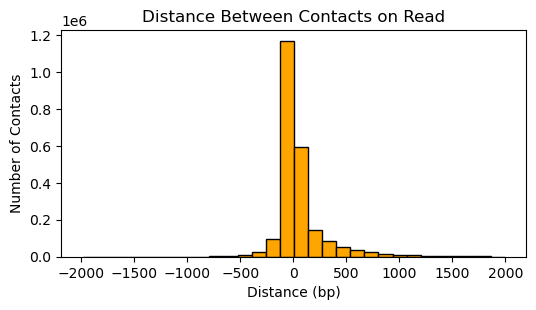

In [6]:
# look at distribution of distances between direct fragments on read

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 6, 3

tmp = df[df['contact_is_direct'] == True]

lb = -2000
ub = 2000

tmp = tmp[(tmp['contact_read_distance'] >= lb) & (tmp['contact_read_distance'] <= ub) ]

plt.hist(tmp['contact_read_distance'], edgecolor='k', bins=30, color='orange')

plt.title('Distance Between Contacts on Read')
plt.xlabel('Distance (bp)')
plt.ylabel('Number of Contacts')

# Filters

In [7]:
# drop clique expanion products
print(f"{df.shape=}")
df = filters.adjacentContactFilter(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(10525887, 38)
df.shape=(2316535, 38)
currentRecords/totalRecords=0.2201

Total Reads 557134 (1.000)
Singletons 145909 (0.262)
Pairs 105723 (0.190)
Multiway 305502 (0.548)
-- -- --
Total Contacts 2316535 (1.000)
cis Contacts 1903661 (0.822)
trans Contacts 412874 (0.178)
-- -- --
Total Contacts 2316535 (1.000)
Intra- Contacts 1903661 (0.822)
Inter- Contacts 412874 (0.178)
-- -- --
Total Contacts 2316535 (1.000)
Direct Contacts 2316535 (1.000)
Indirect Contacts 0 (0.000)


In [8]:
# break

In [9]:
# remove read-level self-loops
print(f"{df.shape=}")
df = filters.selfLoopFilter(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(2316535, 38)
df.shape=(1615559, 38)
currentRecords/totalRecords=0.1535


mapq.shape=(3231118, 2)
mapq.shape=(967332, 2)


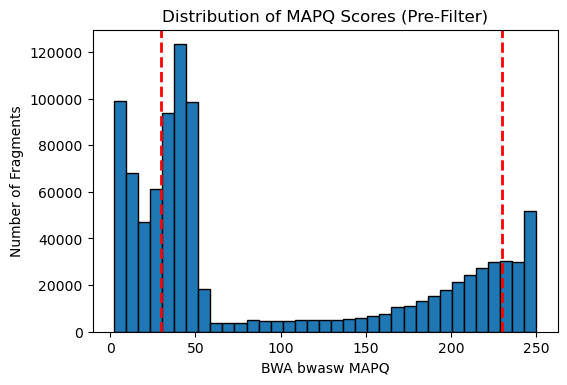

In [10]:
# add histogram of mapq scores

lb = 30 # default lower and upper bounds
ub = 230

mapq = pcu.getFragmentMAPQ(df)
print(f"{mapq.shape=}")
mapq = mapq.drop_duplicates() # drop identical fragments
print(f"{mapq.shape=}")


plt.rcParams['figure.figsize'] = 6, 4
t = plt.hist(mapq['mapq'], bins=35, edgecolor='k')

plt.title('Distribution of MAPQ Scores (Pre-Filter)')
plt.xlabel('BWA bwasw MAPQ')
plt.ylabel('Number of Fragments')


plt.axvline(x=lb, ls="--", c='r', lw=2)
plt.axvline(x=ub, ls="--", c='r', lw=2)

In [11]:
# mapping quality filter
print(f"{df.shape=}")
df = filters.mapQFilter(df, lowerBound=lb, upperBound=ub) # from above 
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(1615559, 38)
df.shape=(560381, 38)
currentRecords/totalRecords=0.0532

Total Reads 277076 (1.000)
Singletons 143556 (0.518)
Pairs 66419 (0.240)
Multiway 67101 (0.242)
-- -- --
Total Contacts 560381 (1.000)
cis Contacts 439777 (0.785)
trans Contacts 120604 (0.215)
-- -- --
Total Contacts 560381 (1.000)
Intra- Contacts 439777 (0.785)
Inter- Contacts 120604 (0.215)
-- -- --
Total Contacts 560381 (1.000)
Direct Contacts 560381 (1.000)
Indirect Contacts 0 (0.000)


mapq.shape=(1120762, 2)
mapq.shape=(456761, 2)


Text(0, 0.5, 'Number of Fragments')

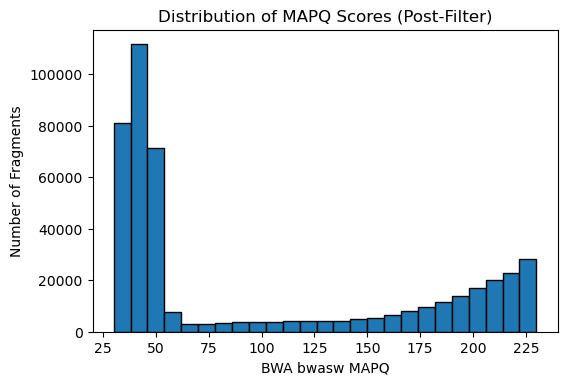

In [12]:
mapq = pcu.getFragmentMAPQ(df)
print(f"{mapq.shape=}")
mapq = mapq.drop_duplicates()
print(f"{mapq.shape=}")


plt.rcParams['figure.figsize'] = 6, 4
t = plt.hist(mapq['mapq'], bins=25, edgecolor='k')

plt.title('Distribution of MAPQ Scores (Post-Filter)')
plt.xlabel('BWA bwasw MAPQ')
plt.ylabel('Number of Fragments')

In [13]:
# a filter for direct contacts too far away on the read
print(f"{df.shape=}")
df = filters.distalContactFilter(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(560381, 38)
df.shape=(552334, 38)
currentRecords/totalRecords=0.0525


In [14]:
# cis contacts within 1kb ON THE REFERENCE are assumed to be amplification bias
print(f"{df.shape=}")
df = filters.closeContactFilter(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(552334, 38)
df.shape=(372304, 38)
currentRecords/totalRecords=0.0354


In [15]:
# filter duplicate contacts: does this make sense? the contact with the higest average MAPQ is retained
print(f"{df.shape=}")
df = filters.duplicateContactFilter(df, retain=1)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(372304, 38)
df.shape=(170881, 40)
currentRecords/totalRecords=0.0162

Total Reads 111826 (1.000)
Singletons 75664 (0.677)
Pairs 22734 (0.203)
Multiway 13428 (0.120)
-- -- --
Total Contacts 170881 (1.000)
cis Contacts 74709 (0.437)
trans Contacts 96172 (0.563)
-- -- --
Total Contacts 170881 (1.000)
Intra- Contacts 74709 (0.437)
Inter- Contacts 96172 (0.563)
-- -- --
Total Contacts 170881 (1.000)
Direct Contacts 170881 (1.000)
Indirect Contacts 0 (0.000)


In [16]:
# for single cells, there can be at most 2 copies of any sequence (ligation product)
print(f"{df.shape=}")
df = filters.ligationProductFilter(df, nProducts=4, verbose=False)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

# quick check of the above
testCounts = filters.getFragmentCounts(df)
print(f"{testCounts.most_common(1)=}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(170881, 40)
df.shape=(55111, 44)
currentRecords/totalRecords=0.0052
testCounts.most_common(1)=[(11612264, 7)]

Total Reads 39884 (1.000)
Singletons 29358 (0.736)
Pairs 7352 (0.184)
Multiway 3174 (0.080)
-- -- --
Total Contacts 55111 (1.000)
cis Contacts 43650 (0.792)
trans Contacts 11461 (0.208)
-- -- --
Total Contacts 55111 (1.000)
Intra- Contacts 43650 (0.792)
Inter- Contacts 11461 (0.208)
-- -- --
Total Contacts 55111 (1.000)
Direct Contacts 55111 (1.000)
Indirect Contacts 0 (0.000)


In [17]:
# filter contacts without suffiecient support from neighboring contacts
print(f"{df.shape=}")

readSupport = False
nReads = 3

df = filters.establishContactSupport(df, windowSize=500000, 
                                     nContacts=6, 
                                     readSupport=readSupport, 
                                     nReads=nReads)

df = filters.supportedContactFilter(df, readSupport=readSupport)

currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(55111, 44)
df.shape=(40448, 47)
currentRecords/totalRecords=0.0038

Total Reads 30848 (1.000)
Singletons 23890 (0.774)
Pairs 5084 (0.165)
Multiway 1874 (0.061)
-- -- --
Total Contacts 40448 (1.000)
cis Contacts 39616 (0.979)
trans Contacts 832 (0.021)
-- -- --
Total Contacts 40448 (1.000)
Intra- Contacts 39616 (0.979)
Inter- Contacts 832 (0.021)
-- -- --
Total Contacts 40448 (1.000)
Direct Contacts 40448 (1.000)
Indirect Contacts 0 (0.000)


In [18]:
# break

# Added Features

Text(0, 0.5, 'Number of Reads')

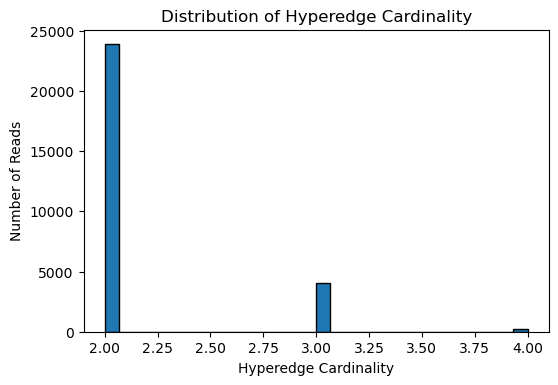

In [19]:
# add the cardinality of the hyperedge
df['edgeOrder'] = df.groupby(["read_name"])["align2_fragment_id"].transform("count")

# map read count back to concatemer multicplitity
orderDict = {}
for i in range(df['edgeOrder'].max()):
    orderDict[math.comb(i, 2)] = i
    
df['hyperedgeOrder'] = df['edgeOrder'].map(orderDict)

res = plt.hist(df['hyperedgeOrder'], edgecolor='k', bins=30)
# res = plt.hist(df['edgeOrder'], edgecolor='k', bins=30, color='orange')
plt.title('Distribution of Hyperedge Cardinality')
plt.xlabel('Hyperedge Cardinality')
plt.ylabel('Number of Reads')

Text(0, 0.5, 'Number of Reads')

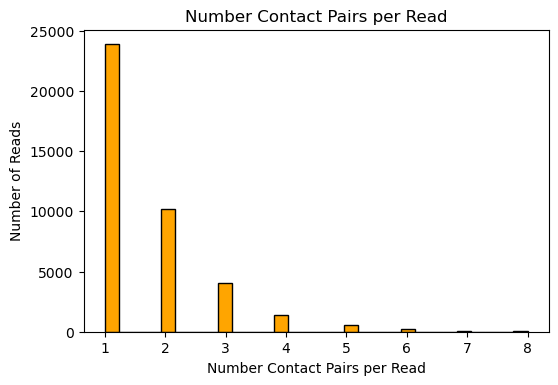

In [20]:
# add the cardinality of the read
res = plt.hist(df['edgeOrder'], edgecolor='k', bins=30, color='orange')
# res = plt.hist(df['edgeOrder'], edgecolor='k', bins=30, color='orange')
plt.title('Number Contact Pairs per Read')
plt.xlabel('Number Contact Pairs per Read')
plt.ylabel('Number of Reads')

In [21]:
# break

df['hyperedgeOrder'].median()=2.0
percOneWay=59.06348892405063
percPairs=25.138449367088604
percHyper=5.792622626582278


Text(0.5, 1.0, 'scPore-C')

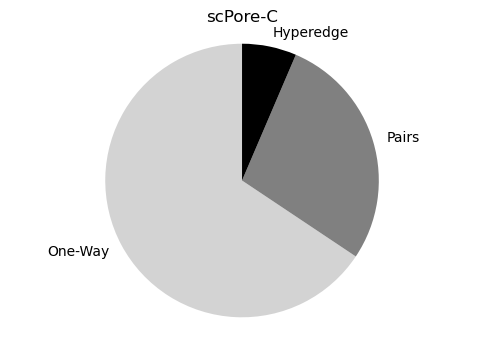

In [22]:
percOneWay = (np.sum(np.where(df['edgeOrder'] == 1, 1, 0)) / len(df)) * 100
percPairs = (np.sum(np.where(df['edgeOrder'] == 2, 1, 0)) / len(df)) * 100
percHyper = (np.sum(np.where(df['edgeOrder'] > 3, 1, 0)) / len(df)) * 100

print(f"{df['hyperedgeOrder'].median()=}")

print(f"{percOneWay=}")
print(f"{percPairs=}")
print(f"{percHyper=}")

labels = ['One-Way', 'Pairs', 'Hyperedge']

sizes = [percOneWay, percPairs, percHyper]
plt.rcParams['figure.facecolor'] = 'w'

fig1, ax1 = plt.subplots()
ax1.pie(sizes, 
        labels=labels, 
        startangle=90,
        colors=['lightgrey', 'grey', 'k'])

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('scPore-C')

# Mapping to the Assembly

In [23]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession,chromEnd,chromStart
0,1,195154279,CM000994.3,NC_000067.7,195154279,0
1,2,181755017,CM000995.3,NC_000068.8,376909296,195154279
2,3,159745316,CM000996.3,NC_000069.7,536654612,376909296
3,4,156860686,CM000997.3,NC_000070.7,693515298,536654612
4,5,151758149,CM000998.3,NC_000071.7,845273447,693515298
5,6,149588044,CM000999.3,NC_000072.7,994861491,845273447
6,7,144995196,CM001000.3,NC_000073.7,1139856687,994861491
7,8,130127694,CM001001.3,NC_000074.7,1269984381,1139856687
8,9,124359700,CM001002.3,NC_000075.7,1394344081,1269984381
9,10,130530862,CM001003.3,NC_000076.7,1524874943,1394344081


In [24]:
# filter out non-chromosomal sections of the genome
print(f"{df.shape=}")
df = filters.chromosomalFilter(df, assembly)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(40448, 49)
df.shape=(40430, 50)
currentRecords/totalRecords=0.0038


In [25]:
# remove y chrom (these are male mice)
print(f"{df.shape=}")
df = filters.removeYChrom(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(40430, 50)
df.shape=(40427, 50)
currentRecords/totalRecords=0.0038


In [26]:
# add the chromosome starting location to each fragment

chromosomeStart = pd.Series(assembly['chromStart'].values, index=assembly['RefSeq accession'].str.strip()).to_dict()

df['align1_chrom_start'] = df['align1_chrom'].astype(str).map(chromosomeStart)
df['align2_chrom_start'] = df['align2_chrom'].astype(str).map(chromosomeStart)

# create genomewide starting position of fragments
df['align1_absolute_position'] = df['align1_fragment_start'] + df['align1_chrom_start']
df['align2_absolute_position'] = df['align2_fragment_start'] + df['align2_chrom_start']

print('done.')

done.


In [27]:
res = pcu.getSummary(df)
pcu.printSummary(res)

Total Reads 30830 (1.000)
Singletons 23874 (0.774)
Pairs 5083 (0.165)
Multiway 1873 (0.061)
-- -- --
Total Contacts 40427 (1.000)
cis Contacts 39595 (0.979)
trans Contacts 832 (0.021)
-- -- --
Total Contacts 40427 (1.000)
Intra- Contacts 39595 (0.979)
Inter- Contacts 832 (0.021)
-- -- --
Total Contacts 40427 (1.000)
Direct Contacts 40427 (1.000)
Indirect Contacts 0 (0.000)


In [28]:
# break

# Binning 

In [29]:
# adding genome-wide binning
    
scale=1000000 # 1MB
# scale=10000000 # 10MB
df, genomeBins = binning.genomeWideBins(df, assembly, scale)
print('genome-wide binning done.')

genome-wide binning done.


In [31]:
# get the binned chromosome positions
chromBins = {}

for idx, row in assembly.iterrows():
    chromBin = binning.returnBin(row['chromEnd'], genomeBins)
    chromBins[row['Chromosome']] = chromBin
    
del chromBins['Y']

print('done.')                      

done.


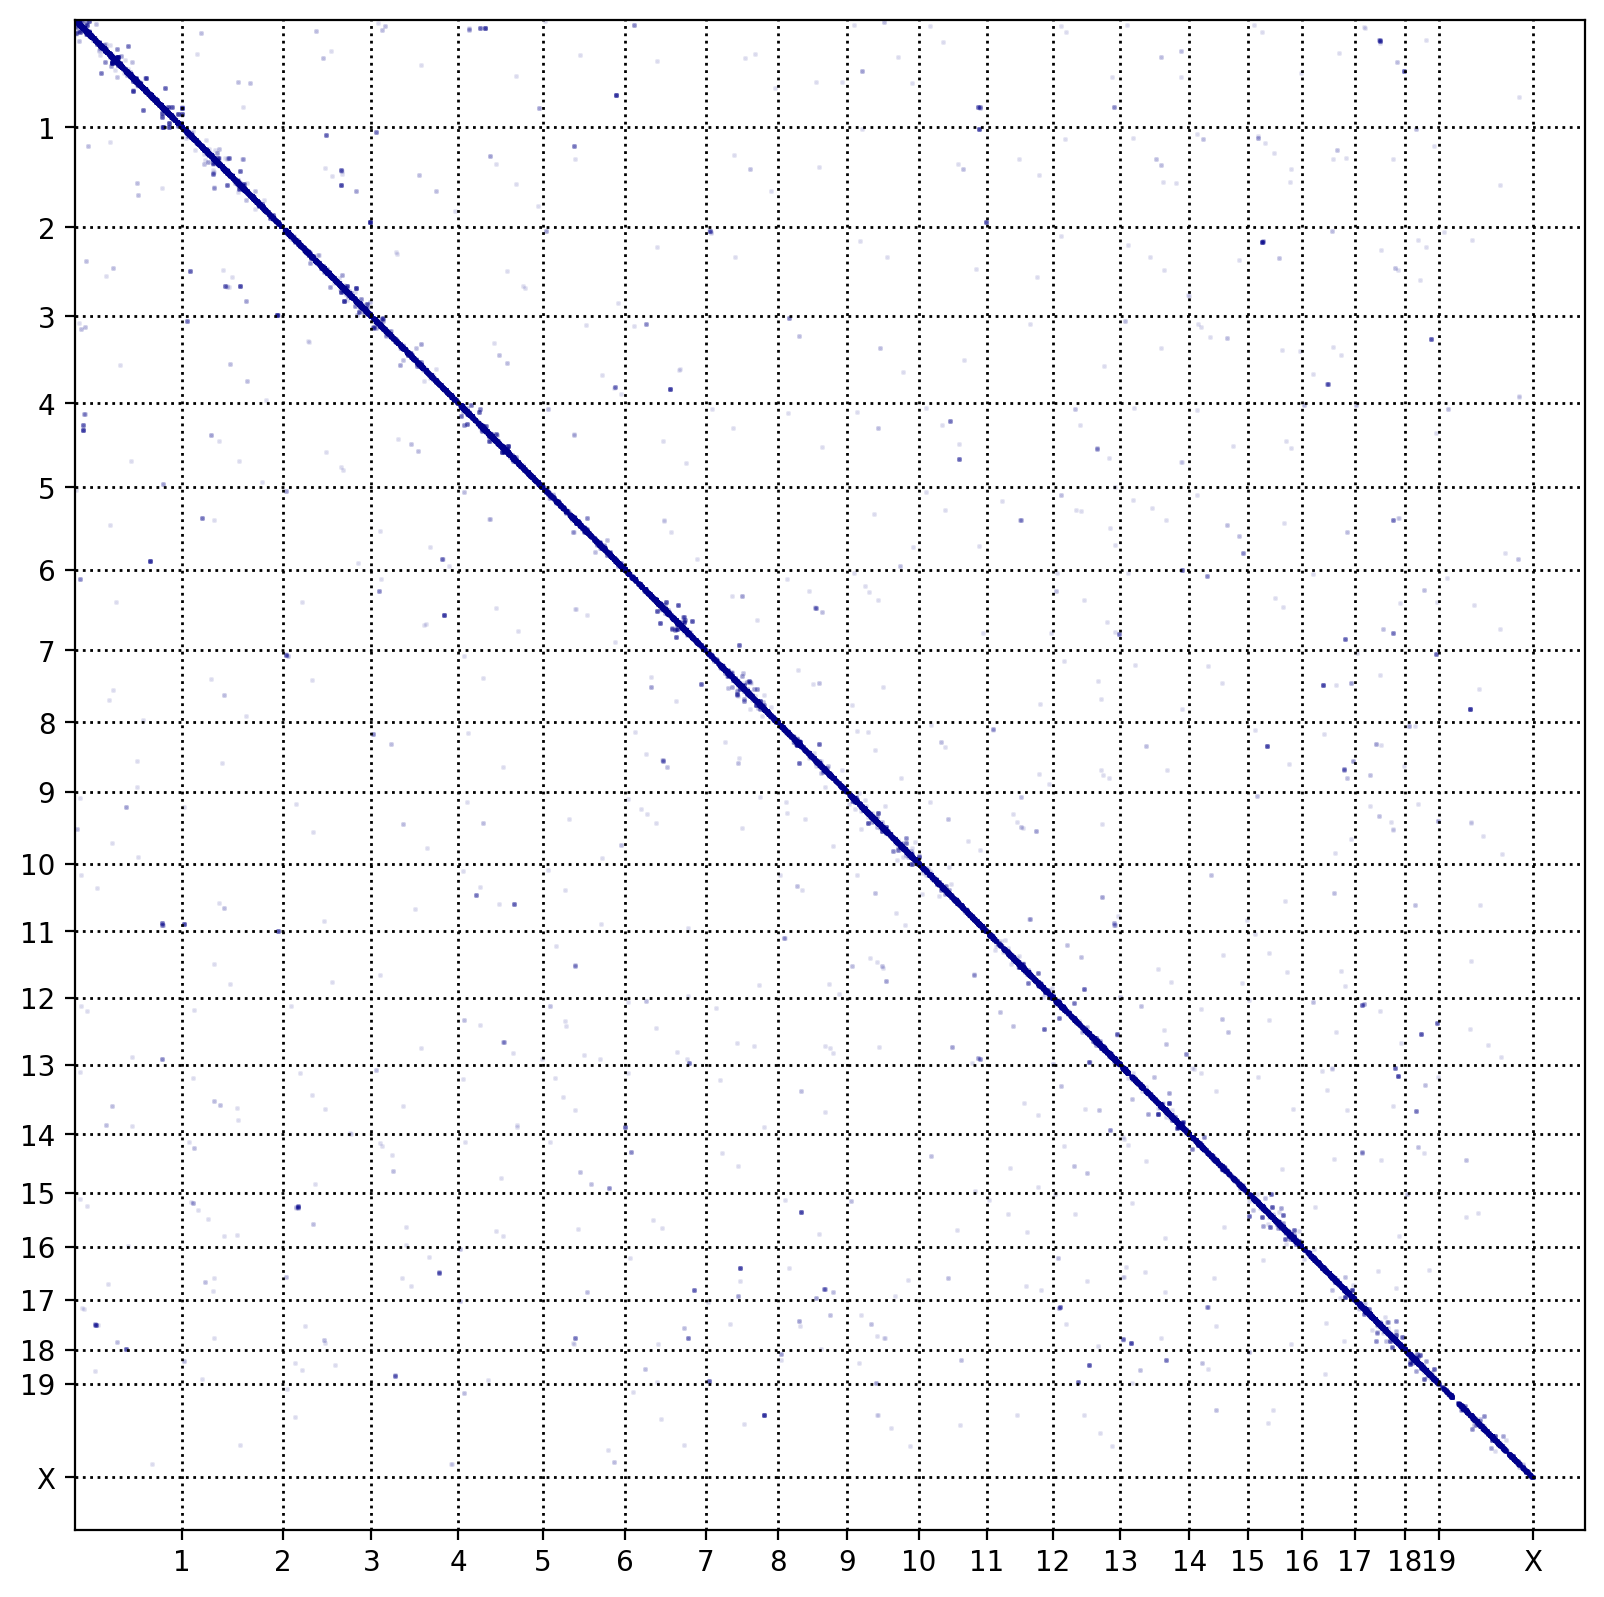

In [32]:
# plot the genome-wide conformation

def genomewidePlot(df, alpha, size, genomeBins, chromBins):
    plt.scatter(df['align1_genomeBin'], 
                df['align2_genomeBin'], 
                marker='s', 
                s=size, 
                alpha=alpha, 
                c='darkblue')

    plt.scatter(df['align2_genomeBin'], 
                df['align1_genomeBin'], 
                marker='s', 
                s=size, 
                alpha=alpha, 
                c='darkblue')


    plt.xlim(0, len(genomeBins) )
    plt.ylim(len(genomeBins), 0)
    ax = plt.gca() # Get current axes object
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.gca().set_aspect('equal', adjustable='box')

    for k, v in chromBins.items():
        plt.axvline(x=v, lw=1, c='k', ls=':')
        plt.axhline(y=v, lw=1, c='k', ls=':')

    plt.xticks(list(chromBins.values()))
    ax.set_xticklabels(list(chromBins.keys()))

    plt.yticks(list(chromBins.values()))
    ax.set_yticklabels(list(chromBins.keys()))
    

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10
alpha = 0.1
size = 0.25

genomewidePlot(df, alpha, size, genomeBins, chromBins)


In [ ]:
# break

# KEEP THIS

In [ ]:
# """

# COOPER: KEEP THIS

# """

# scale=10000000
# kb100, genomeBins = genomeWideBins(df, assembly, scale)


# grped = kb100.groupby(['align1_genomeBin', 'align2_genomeBin'])['read_name'].count().reset_index() # NOTE: not counting unique here

# binBin = grped.pivot(*grped)
# binBin = np.log(binBin) # log scale
# binBin = binBin.fillna(0)

# missing = np.setxor1d(binBin.index, binBin.columns)

# # keep only symmetric entries
# binBin = binBin.drop(index=missing, errors='ignore')
# binBin = binBin.drop(missing, axis=1, errors='ignore')

# # symmetrize
# binBin = binBin + binBin.T - np.diag(np.diag(binBin))

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 15, 15

# sns.heatmap(binBin, 
#             cmap='viridis',
#             square=True,
#                 cbar_kws={'fraction':0.046, 'pad':0.04})


In [ ]:
# @todo interchromosomal unique reads and effects of clique expansion 

# Inter Chromosomal Contact Analysis

totalContacts=40427
numInter=832
numInter/totalContacts=0.021


Text(0, 0.5, 'Number of Reads')

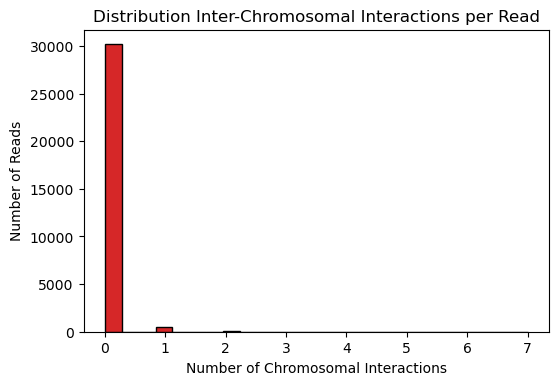

In [33]:
df['inter_edge'] = np.where(df['align1_chrom'] != df['align2_chrom'],1, 0)

totalContacts = len(df)
numInter = np.sum(df['inter_edge'])

print(f"{totalContacts=}")
print(f"{numInter=}")
print(f"{numInter/totalContacts=:.3f}")


grped = df.groupby('read_name').agg(
        numInterContacts=('inter_edge', np.sum),
        totalContacts=('align1_fragment_id', 'count')
).reset_index()

grped['percContactInter'] = grped['numInterContacts'] / grped['totalContacts']

grped.head()


plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['figure.dpi'] = 100
t = plt.hist(grped['numInterContacts'], bins=25, edgecolor='k', color='C3')

ax = plt.gca()
# ax.set_yscale('log')

plt.title('Distribution Inter-Chromosomal Interactions per Read')
plt.xlabel('Number of Chromosomal Interactions')
plt.ylabel('Number of Reads')

In [34]:
df['mean_mapq'] = (df['align1_mapping_quality'] + df['align2_mapping_quality']) / 2

isInter = df[df['inter_edge'] == 1]
isIntra = df[df['inter_edge'] == 0]

meanIntra = isIntra['mean_mapq'].mean()
stdIntra = isIntra['mean_mapq'].std()

meanInter = isInter['mean_mapq'].mean()
stdInter = isInter['mean_mapq'].std()

print(f"{meanIntra=:.3f} (std = {stdIntra:.3f})")
print(f"{meanInter=:.3f} (std = {stdInter:.3f})")

stats.ttest_ind(isInter['mean_mapq'], isIntra['mean_mapq'], permutations=1000)

meanIntra=60.965 (std = 35.464)
meanInter=60.812 (std = 36.176)


Ttest_indResult(statistic=-0.12253333077369963, pvalue=0.9032)

In [ ]:

df['Contact Type'] = np.where(df['inter_edge'] == 1, 'Inter', 'Intra')

plt.rcParams['figure.figsize'] = 6,5
plt.rcParams['figure.dpi'] = 100

b = sns.boxplot(x='contact_is_direct',
            y="mean_mapq", 
            hue='Contact Type',
            data=df,
            linewidth=2.5,
            palette='Set1')

plt.title('Inter vs Intra Mapping Quality')
plt.xlabel('Contact is Direct')
plt.ylabel('Mean Contact Mapping Quality')

plt.legend(title='Contact Type', loc=1)


In [ ]:
# break

In [ ]:
grped = df.groupby(['align1_chrom', 'align2_chrom'])['read_name'].nunique().reset_index()

refseq2Chrom = pd.Series(assembly['Chromosome'].values, index=assembly['RefSeq accession'].str.strip()).to_dict()

grped['align1_chromName'] = grped['align1_chrom'].astype(str).map(refseq2Chrom)
grped['align2_chromName'] = grped['align2_chrom'].astype(str).map(refseq2Chrom)

# drop zero-value counts (because the chrom is a category data type)

grped = grped[grped['read_name'] > 0].reset_index()

chromChrom = grped.pivot(index='align1_chromName', columns=['align2_chromName'])['read_name']

chromChrom = np.log(chromChrom) # log scale
chromChrom = chromChrom.fillna(0)


# sort the chromosomes
chromOrder = list(refseq2Chrom.values())[:-1]
chromChrom = chromChrom[chromOrder]
chromChrom = chromChrom.reindex(chromOrder)

# make symmetric
chromChrom = chromChrom + chromChrom.T - np.diag(np.diag(chromChrom))

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 14, 14
        
sns.heatmap(chromChrom, 
            annot=True, 
            fmt='.2g',
            cmap='viridis',
            linewidths=.5,
            square=True,
            cbar_kws={'fraction':0.046, 'pad':0.04})
        
plt.title('Number of Inter-Chromosomal Contacts (post-filter)')
plt.xlabel('')
plt.ylabel('')

In [ ]:
# break

# Chromosome Selection

In [ ]:
# subset the data to a single chromosome
chomosome = 2
chrom_assembly = assembly.loc[assembly['Chromosome'] == str(chomosome)]
refseq = chrom_assembly['RefSeq accession'].tolist()[0].strip()
chromLength = chrom_assembly['Total length'].tolist()[0]
    
chr2 = pcu.filterChomosome(df, refseq)
print(f"{chr2.shape=}")

In [ ]:
# bin data within a chromosome
# scale = 100000 #100kb scale
scale = 1000000 # 1mb scale


chr2Bins = binning.getBins(chromLength, scale)
print(f"{len(chr2Bins)=}")


chr21mb = binning.chromosomeBinData(chr2, chr2Bins, label='chrom2')
print('done.')

# Construct pseudo Hi-C Matrices

In [ ]:


A = pcu.constructHiCSingleChromosome(chr2)
print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 10, 10
        
sns.heatmap(A, 
            cmap='viridis',
            square=True,
            cbar_kws={'fraction':0.046, 'pad':0.04})
        
# plt.title('Number of Intra-Chromosomal Contacts (post-filter)')
# plt.xlabel('')
# plt.ylabel('')
plt.axis(False)

In [ ]:
chr2.columns

In [ ]:
# break

In [ ]:
# chr2['mean_score'] = (chr2['align1_mapping_quality'] + chr2['align2_mapping_quality']) / 2


# grped = chr2.groupby(['align1_chrom2Bin', 'align2_chrom2Bin'])['mean_score'].mean().reset_index() # NOTE: not counting unique here

# binBin = grped.pivot(*grped)

# binBin = binBin.fillna(0)

# missing = np.setxor1d(binBin.index, binBin.columns)

# # keep only symmetric entries
# binBin = binBin.drop(index=missing, errors='ignore')
# binBin = binBin.drop(missing, axis=1, errors='ignore')

# # symmetrize
# binBin = binBin + binBin.T - np.diag(np.diag(binBin))


# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['figure.figsize'] = 10, 10
        
# sns.heatmap(binBin, 
#             cmap='plasma',
#             square=True,
#             cbar_kws={'fraction':0.046, 'pad':0.04})

# # plt.title('Number of Intra-Chromosomal Contacts (post-filter)')
# # plt.xlabel('')
# # plt.ylabel('')
# plt.axis(False)

# Single Chromosome Plotting

In [ ]:
params = {
    'figdpi' : 100,
    'figsize' : (6,6),
    'size' : 1,
    'alpha' : 0.1,
#     'color' : np.log(chr2['edgeOrder']),
    'color' : 'darkblue',
}

# plt.set_cmap('gnuplot_r')
hicPlot.plotHiCscatter(chr2, bin1='align1_chrom2Bin', bin2='align2_chrom2Bin', params=params)


# clb = plt.colorbar(fraction=0.046, pad=0.04, ticks=[np.min(np.log(chr2['edgeOrder'])), np.max(np.log(chr2['edgeOrder']))])
# clb.ax.set_yticklabels(['low', 'high'])
# clb.ax.set_title('Contact Order',fontsize=8)

In [ ]:
chr2.columns

In [ ]:


def getDistanceFromDiagonal(df, scale = 1000000):
    """A function to return the distance of a contact from the diagonal defined
    by alignment 1"""
    
    dists = []
    
    for idx, row in df.iterrows():
        
        dist = np.abs(row['align2_fragment_start'] - row['align1_fragment_start']) / scale
        
#         diag = np.array([row['align1_fragment_start'], row['align1_fragment_start'] ])
#         point = np.array([row['align1_fragment_start'], row['align2_fragment_start'] ])
#         dist = (point - diag) / scale
        
        
        dists.append(dist)
        
    df['hieght'] = dists
    return df
        

chr2 = getDistanceFromDiagonal(chr2)

print(f"{chr2['hieght'].max()}")

hieghtThreshold = 30 # in bins
tmp = chr2[chr2['hieght'] < hieghtThreshold]


plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 10, 5

plt.scatter(tmp['align1_chrom2Bin'], 
            tmp['hieght'], 
            color='darkblue',
            s=10,
            alpha=0.1)



    

In [ ]:
rotation_in_degrees = -45

A = constructHiCSingleChromosome(chr2)
A = A.to_numpy()

nBp = 150
hypotenuse = (np.sqrt(2) * nBp) - 0.5
hieght = np.sqrt(nBp**2 - (hypotenuse**2/4))
# hieght = 5

tmp = A[0:nBp, 0:nBp]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5
fig = plt.figure()
ax = fig.add_subplot(111)
tr = transforms.Affine2D().rotate_deg(rotation_in_degrees) + ax.transData

"""
none, antialiased, hanning, hermite, catrom, sinc
"""

ax.imshow(tmp, 
          transform=tr, 
          aspect='equal', 
          cmap='Reds',
          interpolation='sinc')

ax.set_xlim(0, hypotenuse) 
ax.set_ylim(0, hieght) 

# format the axes
ticks = [-1, hypotenuse]
tickLabels = [1, nBp]

ax.set_xticks(ticks, minor=False)
ax.set_xticklabels(tickLabels) 

ticks = [0, hieght]
tickLabels = [1, nBp]

ax.set_yticks(ticks, minor=False)
ax.set_yticklabels(tickLabels) 